In [1]:
# Setup

import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

from customModel import *

In [2]:
device = 'cuda:1'
inputs = np.load('./inputs.npy')
outputs = np.load('./outputs.npy')

print(inputs.shape, outputs.shape)

(100, 2, 512, 512) (100, 2, 512, 512)



Displaying frames for examples


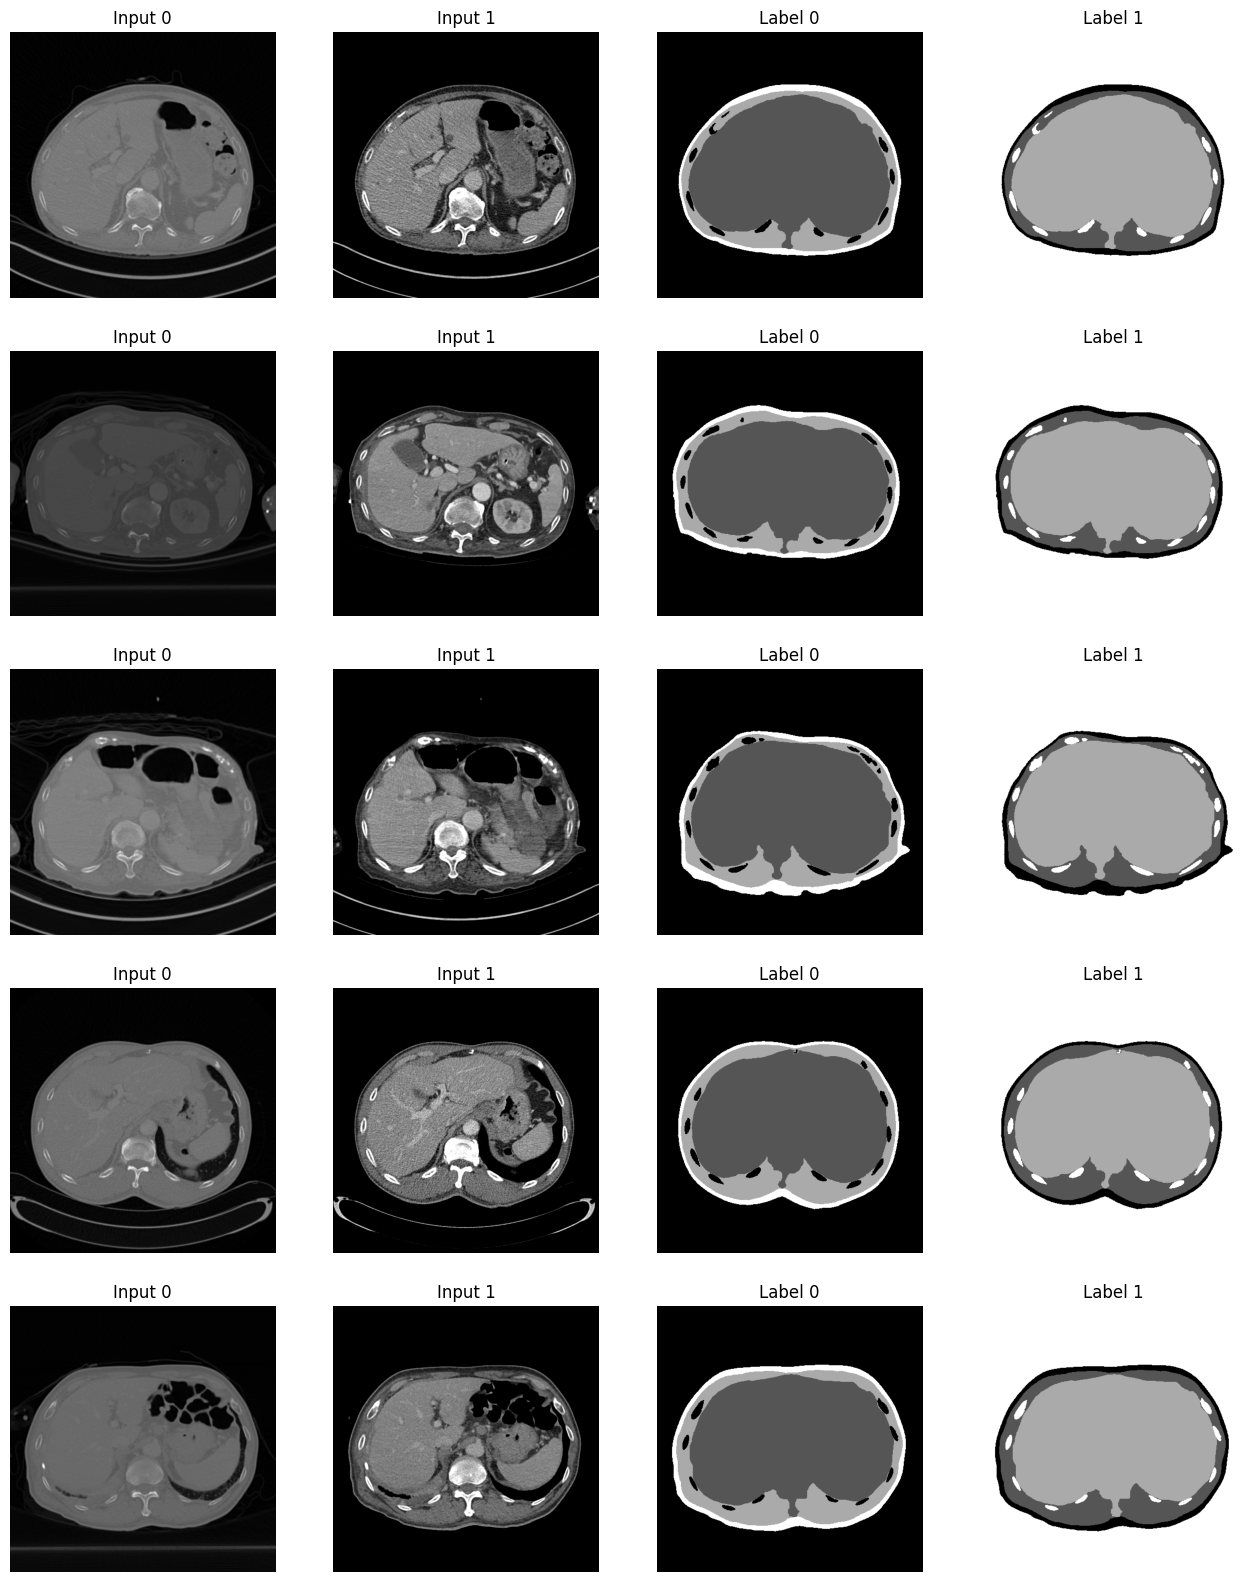

In [3]:
# Data Visualization
# Construct a figure on which we will visualize the images.
datalen = 5
datasize = 4
fig, axes = plt.subplots(datalen, datasize, figsize=(datasize*4, datalen*4))

# Plot each of the sequential images for one random data example.
data_choices = np.random.choice(range(len(inputs)), size=5)
num = 0
for idx, ax in enumerate(axes.flat):
    if (idx > 0) & (idx % 4 == 0) :
        num += 1
    data_choice = data_choices[num]

    if idx % 4 < 2 :
        ax.imshow(np.squeeze(inputs[data_choice][idx-num*4]), cmap="gray")
    else :
        ax.imshow(np.squeeze(outputs[data_choice][idx-num*4-2]), cmap="gray")
    
    if idx % 4 < 2 :
        title = f"Input {idx%4}"
    else :
        title = f"Label {idx%4-2}"
    ax.set_title(title)
    ax.axis("off")

# Print information and display the figure.
print(f"\nDisplaying frames for examples")
plt.show()

In [4]:
# Build Model

num_classes = 2
batch_size, channel, height, width = inputs.shape
x = torch.Tensor(inputs[:1])
vit = ViT(in_channels=channel, num_classes=num_classes)
# pred = vit(x)

# print(pred.shape)

In [5]:
# custom dataset
dataset = customDataset(X=inputs, Y=outputs)
batch_size = 5
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# test dataloader
batch_iterator = iter(dataloader)
inputs, labels = next(batch_iterator)
print(inputs.size(), labels.size())

torch.Size([5, 2, 512, 512]) torch.Size([5, 2, 512, 512])


In [6]:
def train_model(net, dataloader, criterion, optimizer, num_epochs) :
    global device
    
    minimumLoss = 100
    device = torch.device(device)
    print("사용장치 :", device)
    
    # 네트워크를 device로
    net.to(device)
    
    # 네트워크 가속화
    torch.backends.cudnn.benchmark = True
    
    # Training
    for epoch in range(num_epochs) :
        
        # epoch 별 훈련 및 검증 루프
        for phase in ['train', 'val'] :
            if phase == 'trian' :
                net.train()
            else :
                net.eval()
            
            epoch_loss = 0.0   # epoch 손실 합
            epoch_corrects = 0 # epoch 정답 수
            
            # 학습하지 않았을 때의 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
            if (epoch == 0) and (phase=='train') :
                continue
            
            if (epoch % 10 == 9) & (phase=='train') :
                print()
                print(f"Epoch {epoch+1}/{num_epochs}", end=' ')
            
            # 데이터 로더에서 미니 배치를 꺼내 루프
            for inputs, labels in dataloader :
                
                # GPU를 사용할 수 있으면 GPU에 데이터 보냄
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # reset optimizer
                optimizer.zero_grad()
                
                # calculate forward propagation
                with torch.set_grad_enabled(phase=='train') :
                    outputs = net(inputs)
                    
                    loss = criterion(outputs, labels)
                    
                    # 훈련 시에는 오차 역전파
                    if phase == 'train' :
                        loss.backward()
                        optimizer.step()
                        
                    # 결과 계산
                    epoch_loss += loss.item() * inputs.size(0) # 손실합계 갱신
                    # epoch_corrects += torch.sum(outputs == labels.data)
                        
            # epoch 별 손실과 정답률 표시
            epoch_loss = epoch_loss / len(dataloader.dataset)

            if epoch % 10 == 9 :
                print(f"{phase} Loss : {epoch_loss:.4f}", end=' ')
                if phase=='train' :
                    t_loss = epoch_loss
                elif phase=='val' :
                    v_loss = epoch_loss
                    if v_loss < minimumLoss :
                        minimumLoss = v_loss
                        fileName = datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + f"_{epoch+1}"+ f"_{t_loss:.4f}" + f"_{v_loss:.4f}_4.pt" # 생성 시간과 개수로 저장
                        torch.save(net, f"./models/{fileName}")
                        print(f"- Model Saved", end=' ')



In [ ]:
vit.train()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(vit.parameters(), lr=0.1)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

num_epochs=300

train_model(vit, dataloader, criterion, optimizer, num_epochs) 

사용장치 : cuda:1


In [ ]:
dataLen = 10
dataSize = 6

fig, axes = plt.subplots(dataLen, dataSize, figsize=(dataSize*4, dataLen*4))

data_choices = np.random.choice(range(len(dataset)), size=dataLen)
num = 0
data_choice = data_choices[num]
x, y = dataset[data_choice]
x = x.unsqueeze(0).to(device)
pred = vit(x).cpu().detach().numpy().squeeze()

x2 = x.cpu().detach().numpy().squeeze()
y2 = y.cpu().detach().numpy().squeeze()

for idx, ax in enumerate(axes.flat) :

    if (idx > 0) & (idx % dataSize == 0) :
        num += 1
        data_choice = data_choices[num]
        x, y = dataset[data_choice]
        x = x.unsqueeze(0).to(device)
        pred = vit(x).cpu().detach().numpy().squeeze()

        x2 = x.cpu().detach().numpy().squeeze()
        y2 = y.cpu().detach().numpy().squeeze()   
    
    if idx % dataSize < 2 :
        ax.imshow(x2[idx-num*dataSize], cmap="gray")
        title = f'Input {idx+1-num*dataSize}'
        ax.set_title(title)
        ax.axis("off")
    elif idx % dataSize < 4 :
        ax.imshow(y2[idx-2-num*dataSize], cmap="gray")
        title = f'Label {idx-2-num*dataSize}'
        ax.set_title(title)
        ax.axis("off")
    else :
        ax.imshow(pred[idx-4-num*dataSize].astype('uint8')*255, 'gray')
        title = f'pred {idx-4-num*dataSize}'
        ax.set_title(title)
        ax.axis("off")

# Print information and display the figure.
print(f"Displaying Train Results")
plt.show()

In [ ]:
vit.train()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(vit.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

num_epochs=300

train_model(vit, dataloader, criterion, optimizer, num_epochs) 

In [ ]:
vit.train()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(vit.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

num_epochs=300

train_model(vit, dataloader, criterion, optimizer, num_epochs) 